In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# Load the final version of the cleaned data
df = pd.read_csv('finaldf2.csv')

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15090 entries, 0 to 15089
Data columns (total 75 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Index No                        15090 non-null  object 
 1   Organization                    15090 non-null  object 
 2   Gender                          15090 non-null  object 
 3   Nationality                     15090 non-null  object 
 4   Hire Date                       15090 non-null  object 
 5   DS Location                     15090 non-null  object 
 6   DS Country                      15090 non-null  object 
 7   Family/Non-Family               15090 non-null  object 
 8   Position_Count                  15090 non-null  int64  
 9   Years of Service                15090 non-null  int64  
 10  Age                             15090 non-null  float64
 11  Hardship_min                    15090 non-null  float64
 12  Hardship_median                 

In [101]:
# Drop unneccesary columns
#'DS Location','DS Country' are dropped as these were for evaluating Hardship level.
mydf = df.drop(['Index No','Hire Date','DS Location','DS Country'], axis=1)

In [102]:
categories = mydf[['Organization', 'Gender', 'Nationality', 'Family/Non-Family']]

In [103]:
cat_dummy = pd.get_dummies(categories, drop_first = True)

In [104]:
mydf2 = mydf.drop(['Organization', 'Gender', 'Nationality', 'Family/Non-Family'], axis=1)
mydf3 = pd.concat([mydf2, cat_dummy], axis = 1)
mydf3.head()

,Position_Count,Years of Service,Age,Hardship_min,Hardship_median,Hardship_max,Min_Incumbent,Max_Incumbent,Add Contingent Worker,Additional Job,...,Nationality_Vanuatu,Nationality_Venezuela,Nationality_Viet Nam,Nationality_Vietnam,Nationality_Yemen,Nationality_Yemen Rep of,Nationality_Yugoslavia,Nationality_Zambia,Nationality_Zimbabwe,Family/Non-Family_N
0,2,5,34.5,4.0,4.0,4.0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,11,44.5,2.0,3.0,5.0,9,14,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,5,34.5,1.0,1.0,1.0,5,5,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,11,44.5,2.0,2.0,3.0,4,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,10,44.5,2.0,2.0,2.0,15,15,0,0,...,0,0,0,0,0,0,0,0,0,0


# Correlation heatmap with selected variables

I will use Spearman correlation coefficient for assessing the strength of the relationship between variables, as the selected variables are mostly ordinal.

* The Spearman rank correlation coefficient: Non-parametric version of the Pearson correlation coefficient. It can deal with ordinal, interval or ratio variables for monotonic relationships. 
* Nonparametric statistics are used when our data are measured on a nominal or ordinal scale of measurement.
* In a monotonic relationship, the variables tend to move in the same relative direction, but not necessarily at a constant rate. In a linear relationship, the variables move in the same direction at a constant rate.
* Pearson's correlation is a measure of the linear relationship between two continuous random variables.

In [105]:
var = mydf3[['Performance_mean',"Gender_Male", "Position_Count", "Years of Service", "Age", "Hardship_max", "Max_Incumbent","Difference_incumbent", "Family/Non-Family_N"]]

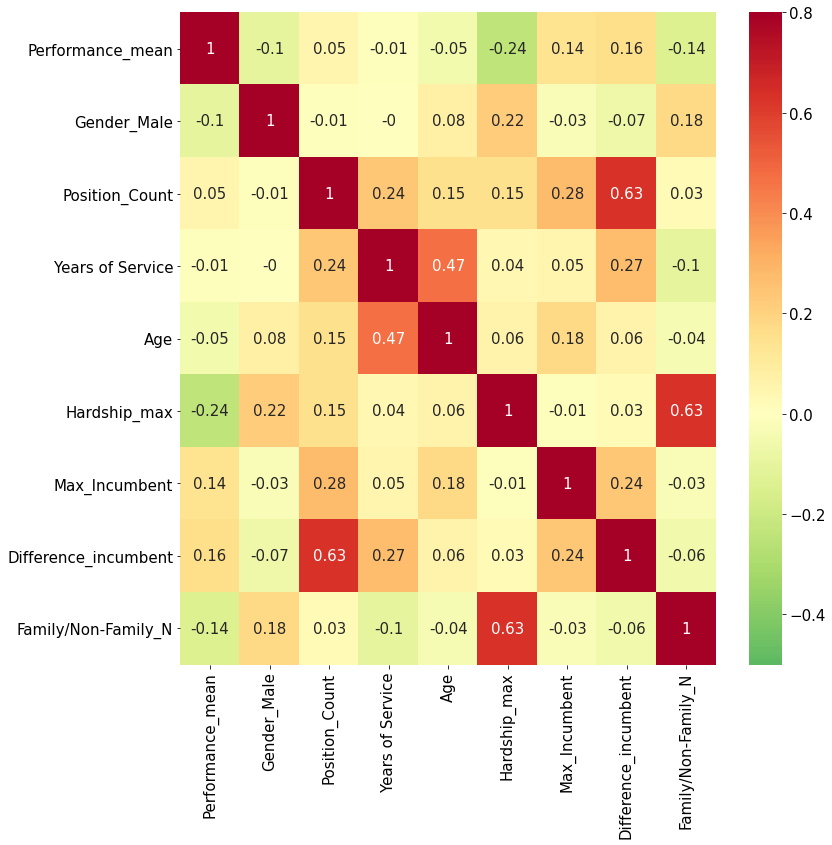

In [106]:
cor_mat = var.corr(method='spearman').round(2)
plt.rcParams['font.size'] = 15
plt.figure(figsize = (12, 12))
sns.heatmap(cor_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

There were some relatively strong positive correlation between variables, such as Difference_incumbent(Promotion) & Position_Count(Total number of positions), Hardship_max & Family/Non-Family, Age & Years of Service.

When it comes to the target variable, Performance_mean, no strong correlation was found. 

# Train/Test split


In [10]:
# Independent variables
X = mydf3.drop('Performance_mean', axis = 1)

# Dependent variables
y = mydf3['Performance_mean']

In [11]:
y.unique()

array([3., 4., 2., 5., 1., 0.])

In [12]:
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)
y

array([3, 3, 3, ..., 5, 3, 4])

In [13]:
from sklearn.model_selection import train_test_split
# Call train_test_split on X, y, test_size = 0.25, and random_state = 246
# Make new variables called X_train, X_test, y_train, and y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                  test_size = 0.25,
                                                  random_state = 246)

# Applying SMOTE for imbalanced dataset
### Target variable(performance rating) is imbalanced
- SMOTE should be applied only to the training dataset
- A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.
- By default, SMOTE will oversample all classes to have the same number of examples as the class with the most examples.
- Reference: 
https://machinelearningmastery.com/multi-class-imbalanced-classification/
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
https://towardsdatascience.com/how-to-effortlessly-handle-class-imbalance-with-python-and-smote-9b715ca8e5a7

Class=3, n=6405 (56.596%)
Class=4, n=3989 (35.248%)
Class=5, n=803 (7.096%)
Class=2, n=67 (0.592%)
Class=1, n=47 (0.415%)
Class=0, n=6 (0.053%)


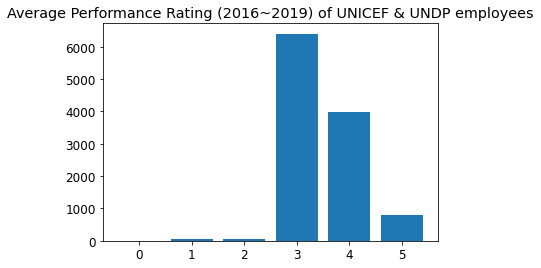

In [14]:
from collections import Counter


# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution
plt.rcParams['font.size'] = 12
plt.bar(counter.keys(), counter.values())
plt.title('Average Performance Rating (2016~2019) of UNICEF & UNDP employees')
plt.show()

Class=3, n=6405 (16.667%)
Class=4, n=6405 (16.667%)
Class=5, n=6405 (16.667%)
Class=2, n=6405 (16.667%)
Class=1, n=6405 (16.667%)
Class=0, n=6405 (16.667%)


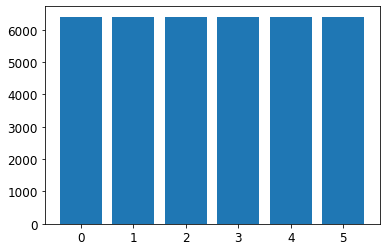

In [15]:
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)

# summarize distribution
counter = Counter(y_train_sm)
for k,v in counter.items():
    per = v / len(y_train_sm) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution
plt.rcParams['font.size'] = 12
plt.bar(counter.keys(), counter.values())
plt.show()

# number of rows 15000 --> 30000

In [16]:
# shape of training and testing data
print(X_train_sm.shape)
print(y_train_sm.shape)
print(X_test.shape)
print(y_test.shape)

(38430, 278)
(38430,)
(3773, 278)
(3773,)


# Scale
- Using Sklearn, standarize the magnitude of the features by scaling the values.
- fit() scaler on X_train and then use that fitted scaler to transform() X_test, in order to avoid data leakage while standardizing my data.

In [17]:
#No need to scale the Y of train data 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_sm)
X_tr_scaled = scaler.transform(X_train_sm)
X_te_scaled = scaler.transform(X_test)

In [18]:
pd.DataFrame(X_tr_scaled, index = X_train_sm.index, columns = X_train_sm.columns).head()

,Position_Count,Years of Service,Age,Hardship_min,Hardship_median,Hardship_max,Min_Incumbent,Max_Incumbent,Add Contingent Worker,Additional Job,...,Nationality_Vanuatu,Nationality_Venezuela,Nationality_Viet Nam,Nationality_Vietnam,Nationality_Yemen,Nationality_Yemen Rep of,Nationality_Yugoslavia,Nationality_Zambia,Nationality_Zimbabwe,Family/Non-Family_N
0,0.0,0.275,0.50,0.6,0.6,0.8,0.352941,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.200,0.50,0.2,0.2,0.2,0.294118,0.277778,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.550,0.50,1.0,1.0,1.0,0.823529,0.777778,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.225,0.50,0.2,0.2,0.4,0.529412,0.500000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.075,0.25,0.6,0.8,0.8,0.294118,0.277778,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

## 1. Start with Multinomial Logistic regression


In [69]:
from sklearn.linear_model import LogisticRegression

lg= LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state = 42)

lg_scores = cross_val_score(lg, X_tr_scaled, y = y_train_sm, scoring = "accuracy", cv = kfold, n_jobs=4)

print('Mean Accuracy: %.3f (%.3f)' % (lg_scores.mean(), lg_scores.std()))


Mean Accuracy: 0.769 (0.034)


### Compare with the model trained with imbalanced dataset

- Cross validation score with imbalanced data is 0.32
- Using SMOTE to deal with imbalanced data issue greatly improves the cross validation accuracy score to 0.768

In [77]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_tr_scaled2 = scaler.transform(X_train)
X_te_scaled2 = scaler.transform(X_test)

In [78]:
# X_tr_scaled, y_train_sm: data with using SMOTE, which is balanced.
score_with_SMOTE = cross_val_score(lg, X_tr_scaled, y_train_sm, scoring = "balanced_accuracy", cv = kfold, n_jobs=-1)
print("score with SMOTE: " + str(score_with_SMOTE.mean()))

# used "balanced accuracy" to deal with imbalanced dataset
# X_tr_scaled2, y_train: data without using SMOTE, which is imbalanced.
score_without_SMOTE = cross_val_score(lg, X_tr_scaled2, y_train, scoring = "balanced_accuracy", cv = kfold, n_jobs=-1)
print("score without SMOTE: " + str(score_without_SMOTE.mean()))

score with SMOTE: 0.7685141816289357
score without SMOTE: 0.32547296419771804


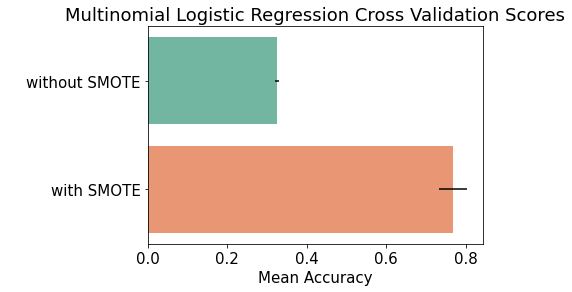

In [107]:
cv_means=[score_without_SMOTE.mean(), score_with_SMOTE.mean()]
cv_std=[score_without_SMOTE.std(), score_with_SMOTE.std()]

cv_scores = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["without SMOTE", "with SMOTE"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_scores, palette="Set2",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g.set_ylabel(" ")
g = g.set_title("Multinomial Logistic Regression Cross Validation Scores")

## 2. Try Random Forest Classifier

- Cross validation score of Random Forest Classifier without tuning parameters is 0.95, which is greatly improved compared to multinomial logistic regression, but it might be overfitting in the training data.

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
rfc = RandomForestClassifier(random_state=42)

In [65]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits = 5)

rf_score = cross_val_score(rfc, X_tr_scaled, y_train_sm, scoring = "accuracy", cv = kfold, n_jobs=-1)

print("Cross validation score of Random Forest Classifier without tuning parameters: " + str(rf_score.mean()))


Cross validation score of Random Forest Classifier without tuning parameters: 0.9508717148061411


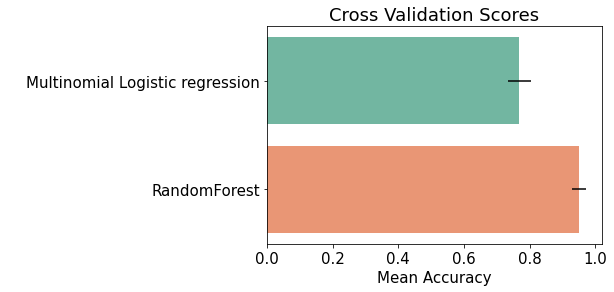

In [108]:
cv_means=[lg_scores.mean(), score1]
cv_std=[lg_scores.std(), rf_score.std()]

cv_scores = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["Multinomial Logistic regression", "RandomForest"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_scores, palette="Set2",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g.set_ylabel(" ")
g = g.set_title("Cross Validation Scores")

### Mean Cross Validation Score has been improved by 18% (0.768 --> 0.950)

## 3. Try other models
- Tried "RandomForest","AdaBoost","GradientBoosting", "XGboost" with balanced dataset (after using SMOTE)
- Random Forest Classifier has the higest cross validation score

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [23]:
kfold = StratifiedKFold(n_splits = 5)
# Modeling step Test differents algorithms 
random_state = 42
classifiers = []

classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(XGBClassifier(learning_rate=0.1,random_state=random_state))


In [24]:
classifiers

[RandomForestClassifier(random_state=42),
 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                    learning_rate=0.1, random_state=42),
 GradientBoostingClassifier(random_state=42),
 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.1, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=42, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None)]

In [25]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_tr_scaled, y = y_train_sm, scoring = "accuracy", cv = kfold, n_jobs=4))


In [26]:
cv_results

[array([0.90983607, 0.96148842, 0.96161853, 0.96096799, 0.96044757]),
 array([0.89045017, 0.93884986, 0.92557897, 0.92857143, 0.92427791]),
 array([0.81407754, 0.86625033, 0.87015353, 0.85050742, 0.84608379]),
 array([0.85883424, 0.93052303, 0.92583919, 0.90788447, 0.91035649])]

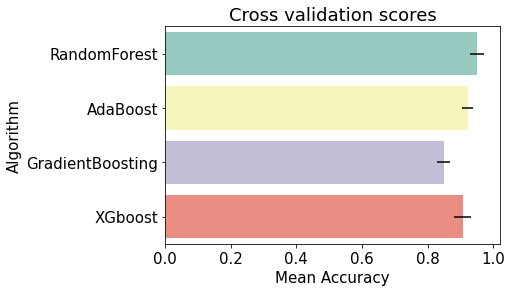

In [109]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["RandomForest","AdaBoost","GradientBoosting", "XGboost"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [28]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.950872,0.020522,RandomForest
1,0.921546,0.016367,AdaBoost
2,0.849415,0.019872,GradientBoosting
3,0.906687,0.025455,XGboost


## Tuning parameters for Random Forest Classifier

- Picked Random Forest Classifier, which had the highest cross validation score, compared to other models ("AdaBoost","GradientBoosting", "XGboost")

## 4-1) Random Forest Classifier with tuning parameters (ver.1)
- First Parameter tuning with RandomizedSearchCV() 
The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively). More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [36]:
rfc.get_params() # checking default paramters 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Parameters of interest

- n_estimators = number of trees in the foreset
- max_features = The number of features to consider when looking for the best split
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [37]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 50, 100],
               'max_features': ['sqrt'],
               'min_samples_leaf': [1, 2, 10],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]}

In [38]:
# Use the random grid to search for best hyperparameters
# n_iter: Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
# rfc = RandomForestClassifier(random_state=42)
random_state = 42
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# add scoring= accuracy

# Fit the random search model
rfc_random.fit(X_tr_scaled, y_train_sm) # took 20 mins

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 50, 100],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [39]:
# If it doesn't show a value for certain parameters, it's bc it's default value.
rfc_random.best_estimator_ 

RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       min_samples_split=5, n_estimators=400, random_state=42)

In [40]:
rfc_random.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [41]:
# best_score_ : Mean cross-validated score of the best_estimator
# Score based on training data. For classification, it's accuracy by default. 
rfc_random.best_score_ 

0.9522248243559718

In [42]:
RFC1 = rfc_random.best_estimator_

In [44]:
score_first_tuning = cross_val_score(RFC1, X_tr_scaled, y_train_sm, scoring = "accuracy", cv = kfold, n_jobs=-1).mean()

In [45]:
print("Mean Cross validation score (5 folds) of first tuned random forest model: " + str(score_first_tuning))

Cross validation score (5 folds) of first tuned random forest model: 0.9556596409055427


### Mean Cross Validation Score has been improved by 0.5% (0.950 --> 0.955)

## 4-2) Random Forest Classifier with tuning parameters (ver.2)

- Try different set of parameters
- Accuracy improved by 0.001 (0.955 --> 0.956) by tuning parameters

In [46]:
random_state = 42

random_grid2 = {'bootstrap': [True, False],
               'max_depth': [50, 100, 200, 500],
               'max_features': ['sqrt'],
               'min_samples_leaf': [1, 2, 10],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]}

# randomized search cv may not go through all combinations. It only went through n_iter times: 30 times in this case. 
rfc_random2 = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid2, n_iter = 30, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rfc_random2.fit(X_tr_scaled, y_train_sm) # about an hour

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [50, 100, 200, 500],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [47]:
rfc_random2.best_estimator_


RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       n_estimators=1600, random_state=42)

In [48]:
rfc_random2.best_estimator_.get_params() 


{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1600,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [49]:
rfc_random2.best_score_

0.9564142596929482

In [50]:
RFC2 = rfc_random2.best_estimator_

In [51]:
score_second_tuning = cross_val_score(RFC2, X_tr_scaled, y_train_sm, scoring = "accuracy", cv = kfold, n_jobs=-1).mean()

In [110]:
print("Mean Cross validation score of the second tuned random forest model: " + str(score_second_tuning))

Mean Cross validation score of the second tuned random forest model: 0.9564142596929482


### Mean Cross Validation Score has been improved by 0.1% (0.955 --> 0.956)

## 5. Final model with test data

In [53]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix


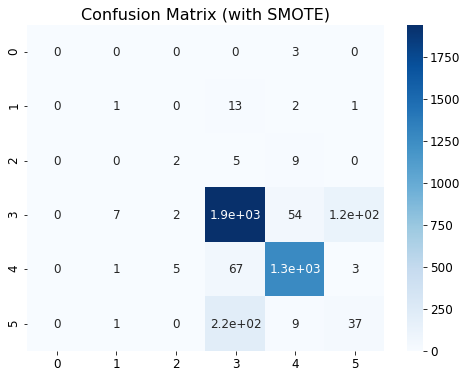

In [55]:
RFC2.fit(X_tr_scaled, y_train_sm)
y_pred = RFC2.predict(X_te_scaled)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

In [56]:
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print('Final Random Forest: Accuracy=%.3f' % (ac))
print('Final Random Forest: f1-score=%.3f' % (f1))
print('Fianl Random Forest: recall-score=%.3f' % (recall))

Final Random Forest: Accuracy=0.861
Final Random Forest: f1-score=0.850
Fianl Random Forest: recall-score=0.861


## Feature Importances with Final Random Forest Model

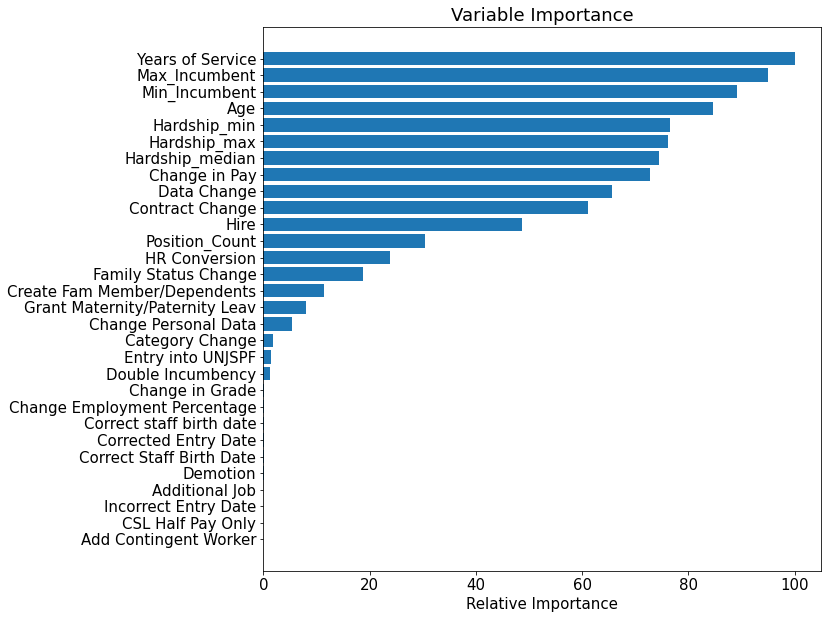

In [121]:
feature_importance = RFC2.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Q) how to interpret?
for example, hardship is important, but how important? does it help performance? or not help?

# Overfitting and Feature Selection
The cross validation score was 0.956, but Final score with the testing data was 0.861. 

This means there might be an overfitting problem with training data.

Therefore, I tried to fix overfitting problem through feature selection (based on Random Forest's in-built feature importance package).

# Feature selection
Random Forest is a popular and very useful feature selection algorithm in machine learning. This algorithm contains an in-built feature importance package, so we do not need to program it separately.

In [134]:
selected_features = list(X.columns[sorted_idx])
selected_features

['Add Contingent Worker',
 'CSL Half Pay Only',
 'Incorrect Entry Date',
 'Additional Job',
 'Demotion',
 'Correct Staff Birth Date',
 'Corrected Entry Date',
 'Correct staff birth date',
 'Change Employment Percentage',
 'Change in Grade',
 'Double Incumbency',
 'Entry into UNJSPF',
 'Category Change',
 'Change Personal Data',
 'Grant Maternity/Paternity Leav',
 'Create Fam Member/Dependents',
 'Family Status Change',
 'HR Conversion',
 'Position_Count',
 'Hire',
 'Contract Change',
 'Data Change',
 'Change in Pay',
 'Hardship_median',
 'Hardship_max',
 'Hardship_min',
 'Age',
 'Min_Incumbent',
 'Max_Incumbent',
 'Years of Service']

In [135]:
X2 = mydf3.drop('Performance_mean', axis = 1)

In [138]:
# Select columns based on Random Forest's feature importances
X2 = X2[selected_features]
X2.head()

,Add Contingent Worker,CSL Half Pay Only,Incorrect Entry Date,Additional Job,Demotion,Correct Staff Birth Date,Corrected Entry Date,Correct staff birth date,Change Employment Percentage,Change in Grade,...,Contract Change,Data Change,Change in Pay,Hardship_median,Hardship_max,Hardship_min,Age,Min_Incumbent,Max_Incumbent,Years of Service
0,0,0,0,0,0,0,0,0,0,0,...,4,0,4,4.0,4.0,4.0,34.5,2,2,5
1,0,0,0,0,0,0,0,0,0,0,...,7,0,6,3.0,5.0,2.0,44.5,9,14,11
2,0,0,0,0,0,0,0,0,0,0,...,4,0,4,1.0,1.0,1.0,34.5,5,5,5
3,0,0,0,0,0,0,0,0,0,0,...,0,12,0,2.0,3.0,2.0,44.5,4,6,11
4,0,0,0,0,0,0,0,0,0,0,...,3,0,4,2.0,2.0,2.0,44.5,15,15,10


In [139]:
y2 = mydf3['Performance_mean']

In [140]:
y2 = LabelEncoder().fit_transform(y2)

# Train/Test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, 
                                                  test_size = 0.25,
                                                  random_state = 246)
# Oversampling(SMOTE) for imbalanced data
X_train_sm2, y_train_sm2 = oversample.fit_resample(X_train2, y_train2)
scaler.fit(X_train_sm2)
X_tr_scaled2 = scaler.transform(X_train_sm2)
X_te_scaled2 = scaler.transform(X_test2)

In [145]:
RFC3 = rfc_random2.best_estimator_
score_selected_feature = cross_val_score(RFC3, X_tr_scaled2, y_train_sm2, scoring = "accuracy", cv = kfold, n_jobs=-1)

In [146]:
# Cross Validation Score lowered down with new selected features
print("Cross validation score with new selected features: " + str(score_selected_feature.mean()))

Cross validation score with new selected features: 0.9519125683060109


Cross validation score with new selected features(0.951) is lower than the second tuned random forest model's score(0.956)

In [149]:
RFC3.fit(X_tr_scaled2, y_train_sm2)
y_pred2 = RFC3.predict(X_te_scaled2)
ac = accuracy_score(y_test2, y_pred2)
f1 = f1_score(y_test2, y_pred2, average='weighted')
recall = recall_score(y_test2, y_pred2, average='weighted')


In [150]:
print('Final Random Forest with selected features: Accuracy=%.3f' % (ac))
print('Final Random Forest with selected features: f1-score=%.3f' % (f1))
print('Fianl Random Forest with selected features: recall-score=%.3f' % (recall))

Final Random Forest with selected features: Accuracy=0.853
Final Random Forest with selected features: f1-score=0.844
Fianl Random Forest with selected features: recall-score=0.853


### Accuracy score has been lowered from 0.861 to 0.853
Feature selection did not help increase the accuracy score

In [ ]:
# 

In [ ]:
# select top 10 in variable importance, and then try model again. 

# 80 - 85. 


In [ ]:
# overfitting 
# then try feature selection or dimensionality reduction. 

# remove outliers ??? shouldn't remove outliers blindly. 3 sdv

# test score again? bc you have done test score already. 

# cross validation score. -- test 



In [ ]:
오버피팅에 관해서:
첫번째 답변 : https://datascience.stackexchange.com/questions/26640/how-to-check-for-overfitting-with-svm-and-iris-data
# 보통은 cv score standard deviation 을 보고 판단

usually we look at the mean validation score only and the standard deviation, 
higher standard deviation shows model overfittting because it means 
maybe model is performing well in a few folds of data
but performing really bad on some folds of data
so then we dont involve the test data at all
but it is ok to involve the test data if you have done so, not the end of the world

so you can do all the steps again like you said and again compare validation and test scores too

====

On larger real-world datasets you are likely to see your test error be higher than your training error, 
with cross-validation providing a lower accuracy than the raw number.
gap suggests high variance.
====

데이터가 가지고 있는 불확실성이나 noise 뿐만 아니라 모든 학습 알고리즘은 두 가지 종류의 에러를 가진다.

1. Bias

2. Variance

Error(X) = noise(X) + bias(X) + variance(X)

noise는 데이터가 가지는 본질적인 한계치이기 때문에 irreducible error라고도 불리며, bias/variance는 모델에 따라 변하는 것이기에 reducible error라고 불린다)
Bias는 데이터 내에 있는 모든 정보를 고려하지 않음으로 인해, 지속적으로 잘못된 것들을 학습하는 경향을 말한다. underfitting 이라고도 한다.

반대로 Variance는 데이터 내에 있는 에러나 노이즈까지 잘 잡아내는 highly flexible models 에 데이터를 fitting시킴으로써, 실제 현상과 관계 없는 random한 것들까지 학습하는 알고리즘의 경향을 의미한다. 이는 overfitting과 관계되어 있다
'Bias'는 트레이닝 데이터를 바꿈에 따라서 알고리즘의 평균 정확도가 얼마나 많이 변하는지를 보여주고, 'Variance'는 특정 입력 데이터에 대해 알고리즘이 얼마나 민감한지를 나타낸다.
low bias 는 새로운 데이터가 들어왔을 때 완전히 다른 형태로 변하게 되고, generality를 잃게 될 것이다 (high variance).
high bias는 새로운 데이터가 들어온다 하더라도 이 모델의 형태는 크게 변하지 않을 것이다 (low variance).
트레이닝 데이터가 아닌 실제 데이터에서 좋은 성능을 내기 위해 이런 tradeoff는 반드시 생길 수 밖에 없으며 이는 bias-variance trade-off 라고 불린다.

출처: https://bywords.tistory.com/entry/번역-유치원생도-이해할-수-있는-biasvariance-tradeoff [건빵의 블로그]


# Save result to csv

In [58]:
prediction = y_pred

original_performance_score = y_test

IndexNo = df['Index No']

In [59]:
result = pd.DataFrame(list(zip(IndexNo, original_performance_score, prediction)), columns =['IndexNo', 'original_performance_score', 'prediction'])
result.head()

,IndexNo,original_performance_score,prediction
0,AAAAAZ,3,3
1,AAADK,3,3
2,AAAKFZ,4,4
3,AAAKKD,3,1
4,AAAKXX,3,5


In [ ]:
#rfc1_result.to_csv('final_result_rfc1.csv', header=True, index=False)